In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

def prepare_data(data_dir, train_dir, val_dir, val_split=0.2):
    """
    Função para organizar os dados em conjuntos de treino e validação.
    
    Parâmetros:
    - data_dir: Diretório com as pastas de cada Pokémon.
    - train_dir: Diretório para armazenar os dados de treino.
    - val_dir: Diretório para armazenar os dados de validação.
    - val_split: Proporção de dados para validação (padrão: 0.2, ou seja, 20% para validação).
    """
    # Criar diretórios de destino, se não existirem
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Verificar se o diretório de dados original existe
    if not os.path.exists(data_dir):
        raise ValueError(f"O diretório de dados original '{data_dir}' não existe. Verifique o caminho e tente novamente.")
    
    # Iterar por cada pasta de Pokémon
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        
        # Verificar se é uma pasta
        if os.path.isdir(class_dir):
            # Criar subpastas para treino e validação
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            
            # Listar todas as imagens da classe
            images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            
            # Verificar se há imagens na pasta
            if len(images) == 0:
                print(f"Atenção: A classe '{class_name}' não contém imagens. Pulei esta classe.")
                continue
            
            # Dividir imagens em treino e validação
            train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)
            
            # Verificar se a divisão gerou conjuntos válidos
            if len(train_images) == 0 or len(val_images) == 0:
                print(f"Atenção: Não foi possível dividir imagens da classe '{class_name}'. Pulei esta classe.")
                continue
            
            # Copiar imagens para o diretório de treino
            for image in train_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))
                
            # Copiar imagens para o diretório de validação
            for image in val_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(val_class_dir, image))
                
            print(f"Classe '{class_name}': {len(train_images)} imagens de treino, {len(val_images)} imagens de validação.")
        else:
            print(f"Atenção: '{class_dir}' não é um diretório. Pulei este item.")

# Diretório original com as imagens dos Pokémons
original_data_dir = "C:\\Users\\filip\\Downloads\\archive\\pokemon"
# Diretórios para treino e validação
train_data_dir = "C:\\Users\\filip\\Downloads\\archive\\pokemon\\train"
val_data_dir = "C:\\Users\\filip\\Downloads\\archive\\pokemon\\val"

# Preparar os dados
prepare_data(original_data_dir, train_data_dir, val_data_dir, val_split=0.2)


Classe 'Abra': 50 imagens de treino, 13 imagens de validação.
Classe 'Aerodactyl': 72 imagens de treino, 19 imagens de validação.
Classe 'Alakazam': 72 imagens de treino, 18 imagens de validação.
Classe 'Arbok': 109 imagens de treino, 28 imagens de validação.
Classe 'Arcanine': 68 imagens de treino, 17 imagens de validação.
Classe 'Articuno': 75 imagens de treino, 19 imagens de validação.
Classe 'Beedrill': 72 imagens de treino, 18 imagens de validação.
Classe 'Bellsprout': 116 imagens de treino, 29 imagens de validação.
Classe 'Blastoise': 116 imagens de treino, 30 imagens de validação.
Classe 'Bulbasaur': 119 imagens de treino, 30 imagens de validação.
Classe 'Butterfree': 100 imagens de treino, 26 imagens de validação.
Classe 'Caterpie': 116 imagens de treino, 29 imagens de validação.
Classe 'Chansey': 92 imagens de treino, 24 imagens de validação.
Classe 'Charizard': 84 imagens de treino, 21 imagens de validação.
Classe 'Charmander': 105 imagens de treino, 27 imagens de validação.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Dataset personalizado para carregar imagens de uma única pasta
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Modelo VAE 
class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2, 1),  # b, 32, 16, 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # b, 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # b, 128, 4, 4
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # b, 256, 2, 2
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 2 * 2, z_dim)
        self.fc_logvar = nn.Linear(256 * 2 * 2, z_dim)
        self.decoder_fc = nn.Linear(z_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # b, 128, 4, 4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # b, 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # b, 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 4, 2, 1),  # b, 3, 32, 32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(z.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Função de perda para o VAE 
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Treinar o modelo VAE com imagens de uma classe específica
def train_vae_for_class(class_dir, num_epochs=10, z_dim=64):
    # Carregar dados da classe usando o dataset personalizado
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    class_data = SingleClassImageDataset(root_dir=class_dir, transform=transform)
    class_loader = DataLoader(class_data, batch_size=32, shuffle=True)

    # Inicializar o modelo, função de perda e otimizador
    vae = VAE(image_channels=3, z_dim=z_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    # Treinamento
    vae.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, data in enumerate(class_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {train_loss / len(class_loader.dataset):.6f}")

    return vae


# Gerar novas imagens usando o VAE 
def generate_images(vae, num_images=100, z_dim=64, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    vae.eval()
    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, z_dim).to(device)
            sample = vae.decode(z).cpu()
            img = transforms.ToPILImage()(sample.squeeze(0))
            img.save(os.path.join(save_dir, f"generated_{i + 1}.png"))


# Função para verificar a quantidade de imagens e gerar novas
def augment_data(data_dir, min_images=100, num_epochs=10, z_dim=64):
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        
        # Verificar se é uma pasta
        if os.path.isdir(class_dir):
            images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            num_images = len(images)

            # Se o número de imagens for menor que o mínimo necessário
            if num_images < min_images:
                print(f"Classe '{class_name}' tem apenas {num_images} imagens. Gerando mais {min_images - num_images} imagens.")
                
                # Treinar o VAE na classe específica
                vae_model = train_vae_for_class(class_dir, num_epochs=num_epochs, z_dim=z_dim)

                # Gerar imagens adicionais
                generate_images(vae_model, num_images=min_images - num_images, z_dim=z_dim, save_dir=class_dir)

                print(f"Imagens geradas para a classe '{class_name}'. Agora tem {min_images} imagens.")
            else:
                print(f"Classe '{class_name}' já possui {num_images} imagens. Nenhuma imagem gerada.")


# Definindo o dispositivo (GPU/CPU)
device = torch.device("cpu")

# Caminho para o diretório de treino
train_data_dir = "C:\\Users\\filip\\Downloads\\archive\\pokemon\\train" 

# Aplicar aumento de dados
augment_data(train_data_dir, min_images=100, num_epochs=10, z_dim=64)


Classe 'Abra' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Aerodactyl' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Alakazam' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Arbok' já possui 109 imagens. Nenhuma imagem gerada.
Classe 'Arcanine' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Articuno' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Beedrill' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Bellsprout' já possui 116 imagens. Nenhuma imagem gerada.
Classe 'Blastoise' já possui 116 imagens. Nenhuma imagem gerada.
Classe 'Bulbasaur' já possui 119 imagens. Nenhuma imagem gerada.
Classe 'Butterfree' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Caterpie' já possui 116 imagens. Nenhuma imagem gerada.
Classe 'Chansey' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Charizard' já possui 100 imagens. Nenhuma imagem gerada.
Classe 'Charmander' já possui 105 imagens. Nenhuma imagem gerada.
Classe 'Charmeleon' já possui 117 ima

# Instanciando o modelo ResNet


In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Definir transformações para treino e validação
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Caminho para os dados de treino e validação
train_data_dir = "C:\\Users\\filip\\Downloads\\archive\\pokemon\\train"
val_data_dir = "C:\\Users\\filip\\Downloads\\archive\pokemon\\val"

# Função para verificar se o diretório de validação está correto
def check_directory_structure(directory):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"O diretório '{directory}' não foi encontrado.")
    
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    if len(classes) == 0:
        raise FileNotFoundError(f"O diretório '{directory}' não contém subpastas com classes.")

    # Verificar se há pelo menos uma imagem válida em cada subpasta
    valid_images = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(valid_images)]
        if len(images) == 0:
            raise FileNotFoundError(f"A classe '{class_name}' no diretório '{directory}' não contém imagens válidas.")
        print(f"Classe '{class_name}' verificada com {len(images)} imagens válidas.")

# Verificar diretório de treino
check_directory_structure(train_data_dir)

# Verificar diretório de validação
check_directory_structure(val_data_dir)

# Carregar datasets de treino e validação
train_data = datasets.ImageFolder(train_data_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_data_dir, transform=val_transforms)

# Criar DataLoaders para treino e validação
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

# Definir o modelo de classificação (usando um modelo pré-treinado ResNet)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 151)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento 
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)
        
        # Fase de Treinamento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zerar os gradientes do otimizador
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e otimização
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        
        print(f"Treino - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        # Fase de Validação
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct_val / total_val
        
        print(f"Validação - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    print("Treinamento completo.")

# Treinar o modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Classe 'Abra' verificada com 98 imagens válidas.
Classe 'Aerodactyl' verificada com 97 imagens válidas.
Classe 'Alakazam' verificada com 96 imagens válidas.
Classe 'Arbok' verificada com 103 imagens válidas.
Classe 'Arcanine' verificada com 97 imagens válidas.
Classe 'Articuno' verificada com 100 imagens válidas.
Classe 'Beedrill' verificada com 97 imagens válidas.
Classe 'Bellsprout' verificada com 103 imagens válidas.
Classe 'Blastoise' verificada com 114 imagens válidas.
Classe 'Bulbasaur' verificada com 118 imagens válidas.
Classe 'Butterfree' verificada com 94 imagens válidas.
Classe 'Caterpie' verificada com 104 imagens válidas.
Classe 'Chansey' verificada com 94 imagens válidas.
Classe 'Charizard' verificada com 98 imagens válidas.
Classe 'Charmander' verificada com 104 imagens válidas.
Classe 'Charmeleon' verificada com 115 imagens válidas.
Classe 'Clefable' verificada com 94 imagens válidas.
Classe 'Clefairy' verificada com 90 imagens válidas.
Classe 'Cloyster' verificada com 

c:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
--------------------
Treino - Loss: 2.9634 Acc: 0.3026
Validação - Loss: 1.5447 Acc: 0.5819
Epoch 2/10
--------------------
Treino - Loss: 1.7172 Acc: 0.5529
Validação - Loss: 0.7575 Acc: 0.7878
Epoch 3/10
--------------------
Treino - Loss: 1.3530 Acc: 0.6425
Validação - Loss: 0.8615 Acc: 0.7627
Epoch 4/10
--------------------
Treino - Loss: 1.2088 Acc: 0.6792
Validação - Loss: 0.6903 Acc: 0.8099
Epoch 5/10
--------------------
Treino - Loss: 1.1012 Acc: 0.7044
Validação - Loss: 0.4942 Acc: 0.8571
Epoch 6/10
--------------------
Treino - Loss: 0.9915 Acc: 0.7315
Validação - Loss: 0.5146 Acc: 0.8649
Epoch 7/10
--------------------
Treino - Loss: 0.8978 Acc: 0.7572
Validação - Loss: 0.4879 Acc: 0.8634
Epoch 8/10
--------------------
Treino - Loss: 0.8472 Acc: 0.7713
Validação - Loss: 0.4483 Acc: 0.8828
Epoch 9/10
--------------------
Treino - Loss: 0.8171 Acc: 0.7742
Validação - Loss: 0.4445 Acc: 0.8787
Epoch 10/10
--------------------
Treino - Loss: 0.7361 Acc: 0.7978
Valida

In [5]:
# Salvando o modelo treinado
torch.save(model.state_dict(), "modelo_pokemon.pth")


# Minha rede feita utilizando um bloco de Convolução + MaxPool + ReLu
## Loss Func utilizada Cross-Entropy

## Treinado apenas para 4 classes 
Pikachu, Charmander, Bulbassauro, Squirtle


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os


class ModelPoke(nn.Module):
    def __init__(self, num_classes=4):
        super(ModelPoke, self).__init__()
        # Bloco 1: Convolução + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  
        self.fc2 = nn.Linear(512, num_classes)
        
        # Função de dropout para evitar overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Bloco 1
        x = self.pool(nn.ReLU()(self.conv1(x)))  # Saída: (32, 112, 112)
        # Bloco 2
        x = self.pool(nn.ReLU()(self.conv2(x)))  # Saída: (64, 56, 56)
        # Bloco 3
        x = self.pool(nn.ReLU()(self.conv3(x)))  # Saída: (128, 28, 28)
        
        # Flatten para entrada na camada totalmente conectada
        x = x.view(-1, 128 * 28 * 28)
        
        # Camadas totalmente conectadas
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Definir transformações para treino e validação
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Caminhos para dados de treino e validação
train_data_dir = r"C:\Users\filip\Downloads\archive\pokemon\trein"
val_data_dir = r"C:\Users\filip\Downloads\archive\pokemon\vel"

# Carregar datasets de treino e validação
train_data = datasets.ImageFolder(train_data_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_data_dir, transform=val_transforms)

# Criar DataLoaders para treino e validação
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

# Inicializar o modelo, função de perda e otimizador
model = ModelPoke(num_classes=151).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train_custom_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)
        
        # Fase de Treinamento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zerar os gradientes do otimizador
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e otimização
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        
        print(f"Treino - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        # Fase de Validação
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct_val / total_val
        
        print(f"Validação - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    print("Treinamento completo.")

# Treinar o modelo personalizado
train_custom_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10
--------------------
Treino - Loss: 2.1110 Acc: 0.4991
Validação - Loss: 0.3848 Acc: 0.8271
Epoch 2/10
--------------------
Treino - Loss: 0.5928 Acc: 0.8015
Validação - Loss: 0.2008 Acc: 0.9549
Epoch 3/10
--------------------
Treino - Loss: 0.3219 Acc: 0.8998
Validação - Loss: 0.0865 Acc: 0.9774
Epoch 4/10
--------------------
Treino - Loss: 0.2384 Acc: 0.9276
Validação - Loss: 0.0818 Acc: 0.9850
Epoch 5/10
--------------------
Treino - Loss: 0.2539 Acc: 0.9258
Validação - Loss: 0.4038 Acc: 0.8496
Epoch 6/10
--------------------
Treino - Loss: 0.3129 Acc: 0.8942
Validação - Loss: 0.1382 Acc: 0.9474
Epoch 7/10
--------------------
Treino - Loss: 0.2237 Acc: 0.9295
Validação - Loss: 0.0415 Acc: 0.9925
Epoch 8/10
--------------------
Treino - Loss: 0.2384 Acc: 0.9276
Validação - Loss: 0.0339 Acc: 0.9925
Epoch 9/10
--------------------
Treino - Loss: 0.1441 Acc: 0.9481
Validação - Loss: 0.0204 Acc: 1.0000
Epoch 10/10
--------------------
Treino - Loss: 0.2069 Acc: 0.9425
Valida

## Muito provavelmente está overfitando um pouco, porém o resultado de teste com dados novos é satisfatório por agora.

In [27]:
# Salvando o modelo treinado
torch.save(model.state_dict(), "modelo_pokemon_BCE.pth")

# Teste com imagens que o modelo nunca viu, 100% de acerto

C:\Users\filip\AppData\Local\Temp\ipykernel_19572\373541526.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


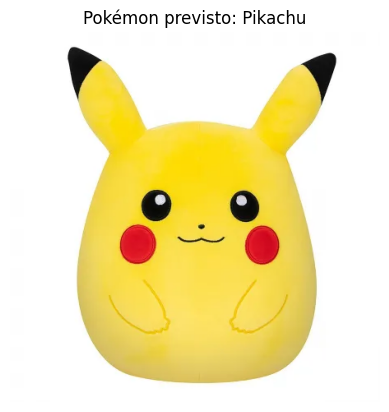

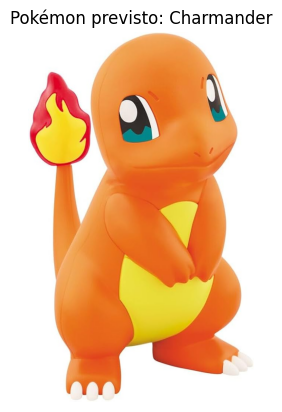

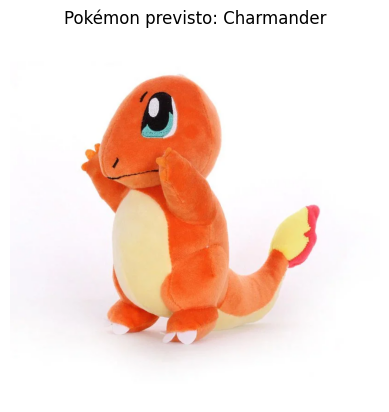

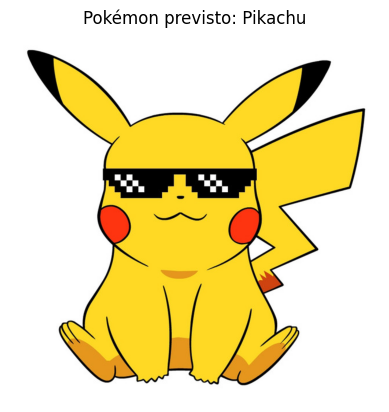

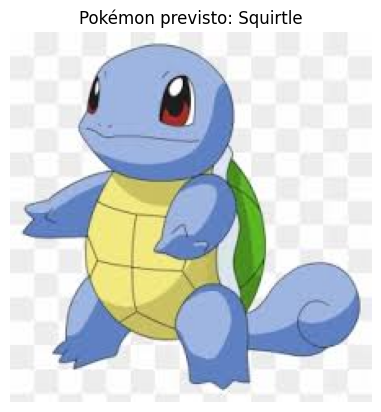

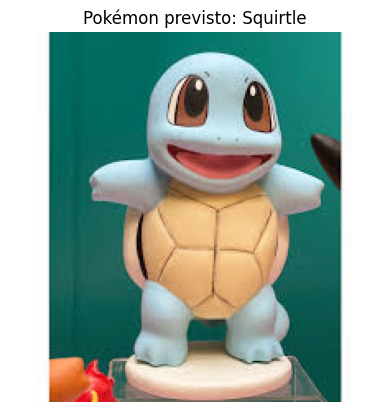

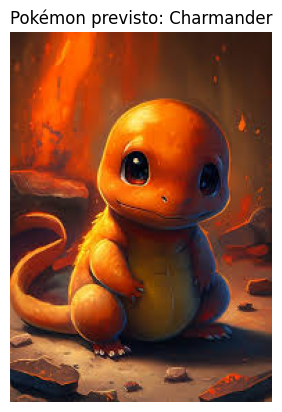

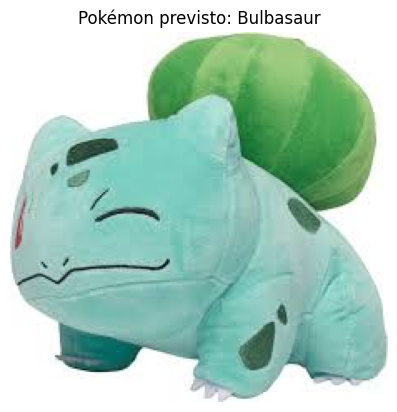

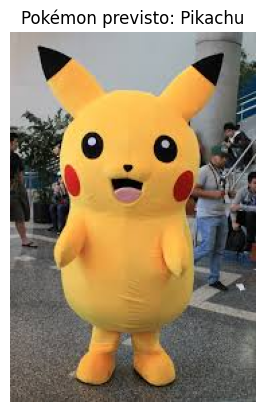

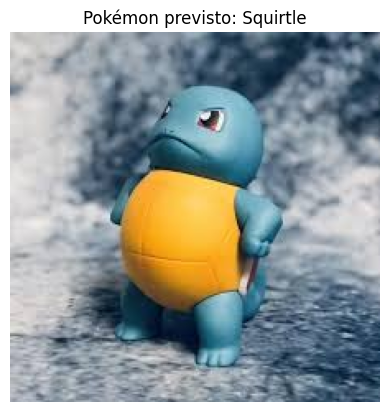

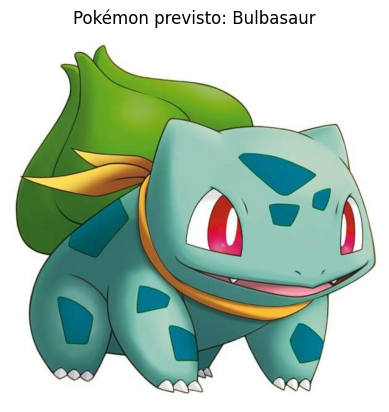

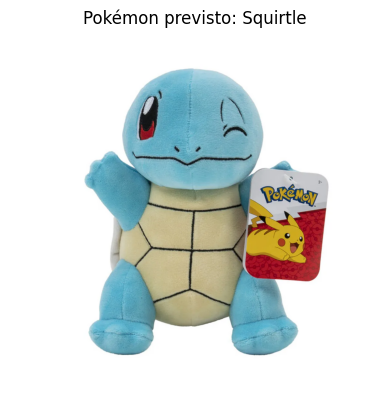

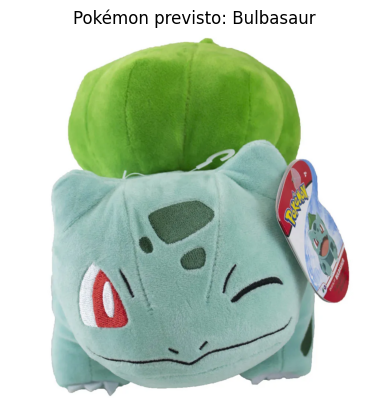

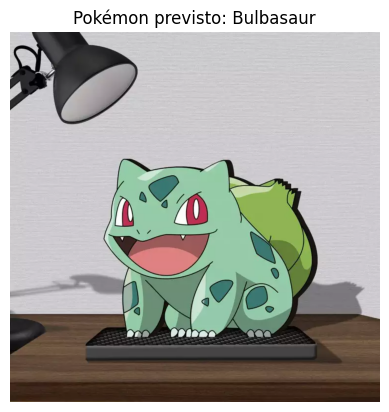

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import os
import matplotlib.pyplot as plt

class ModelPoke(nn.Module):
    def __init__(self, num_classes=151):
        super(ModelPoke, self).__init__()
        # Bloco 1: Convolução + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  
        self.fc2 = nn.Linear(512, num_classes)
        
        # Função de dropout para evitar overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Bloco 1
        x = self.pool(nn.ReLU()(self.conv1(x)))  # Saída: (32, 112, 112)
        # Bloco 2
        x = self.pool(nn.ReLU()(self.conv2(x)))  # Saída: (64, 56, 56)
        # Bloco 3
        x = self.pool(nn.ReLU()(self.conv3(x)))  # Saída: (128, 28, 28)
        
        # Flatten para entrada na camada totalmente conectada
        x = x.view(-1, 128 * 28 * 28)
        
        # Camadas totalmente conectadas
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    # Inicializar o modelo
model = ModelPoke()

# Carregar os pesos salvos no modelo
model_path = r'C:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\modelo_pokemon_BCE.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Definir o modelo em modo de avaliação

# Definir as transformações da imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajuste para o tamanho usado no treinamento
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Ajuste conforme necessário
])

# Carregar e pré-processar a imagem
image_path = r'C:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\imagens\51VLw2O+odL._AC_UF894,1000_QL80_.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Adicionar uma dimensão para o batch

# Realizar a previsão
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)  

# Dicionário de mapeamento (exemplo, substitua pelos seus dados reais)
class_names = {
    0: 'Bulbasaur',
    1: 'Charmander',
    2: 'Pikachu',
    3: 'Squirtle',
    # Adicione todas as classes conforme necessário
}

# Caminho da pasta com as imagens
image_folder = r'C:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\imagens'

# Listar todas as imagens na pasta
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg','jfif','webp'))]

# Prever e plotar cada imagem
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    
    # Carregar e pré-processar a imagem
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Adicionar uma dimensão para o batch

    # Realizar a previsão
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)  # Use para multi-classe

    # Mostrar a imagem com a previsão
    plt.imshow(image)
    plt.title(f'Pokémon previsto: {class_names[predicted.item()]}')
    plt.axis('off')
    plt.show()

# Testes feitos usando ResNet treinado com as 151 classes

C:\Users\filip\AppData\Local\Temp\ipykernel_16448\3398774116.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'modelo_pokemon.pth'))


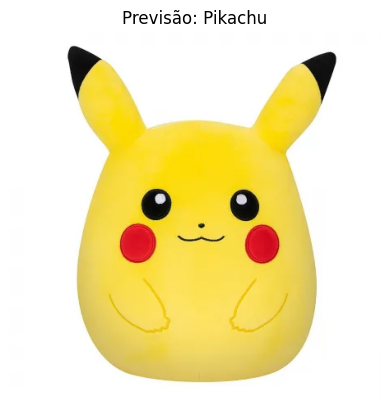

Imagem: 180_squishmallows_pelucia_de_25cm_pikachu_7829_1_5c8c8eccf2825e5f1d4bc9cb33e2485f.webp - Rótulo previsto: Pikachu


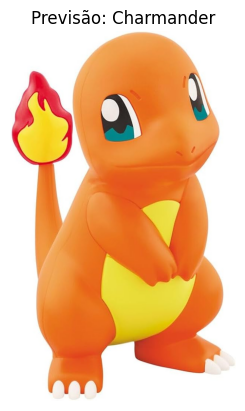

Imagem: 51VLw2O+odL._AC_UF894,1000_QL80_.jpg - Rótulo previsto: Charmander


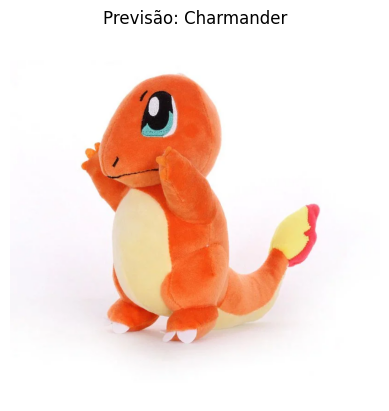

Imagem: 96a4142e9b.webp - Rótulo previsto: Charmander


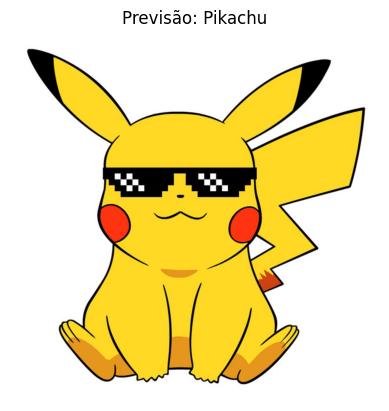

Imagem: ab67616d0000b273cfeae645958e9248abff0710.jfif - Rótulo previsto: Pikachu


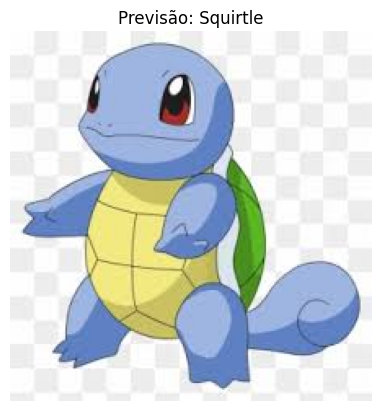

Imagem: images (1).jfif - Rótulo previsto: Squirtle


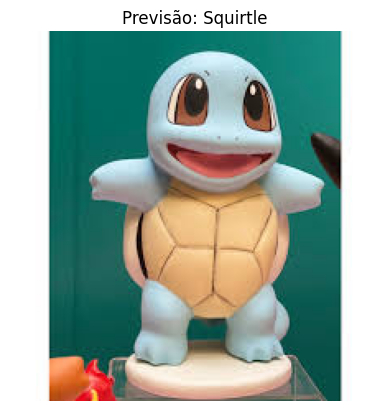

Imagem: images (2).jfif - Rótulo previsto: Squirtle


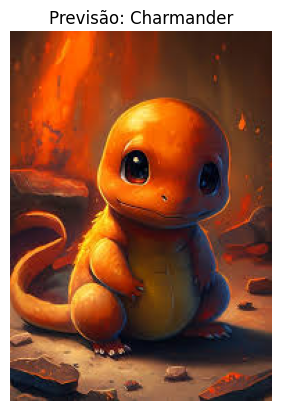

Imagem: images (3).jfif - Rótulo previsto: Charmander


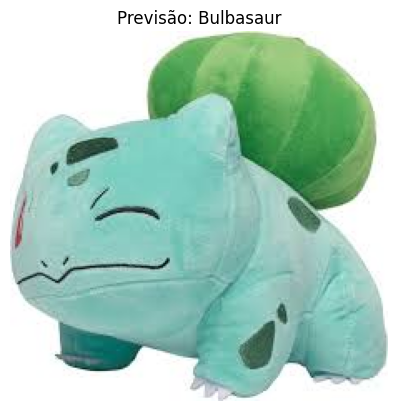

Imagem: images (4).jfif - Rótulo previsto: Bulbasaur


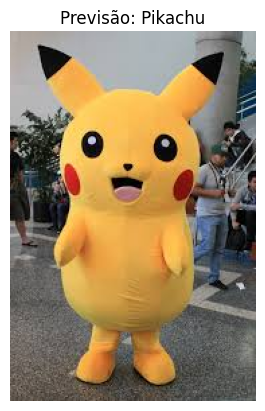

Imagem: images (5).jfif - Rótulo previsto: Pikachu


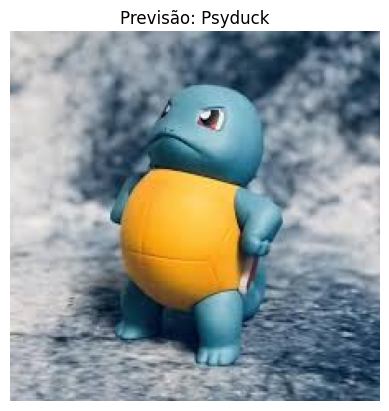

Imagem: images.jfif - Rótulo previsto: Psyduck


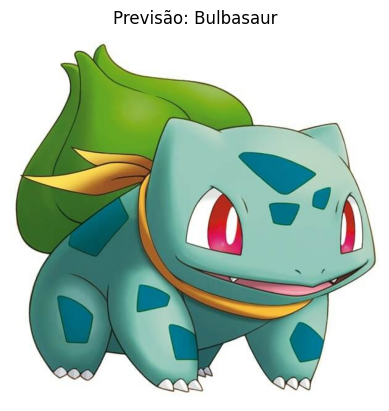

Imagem: pokemon-bulbasaur.jpg - Rótulo previsto: Bulbasaur


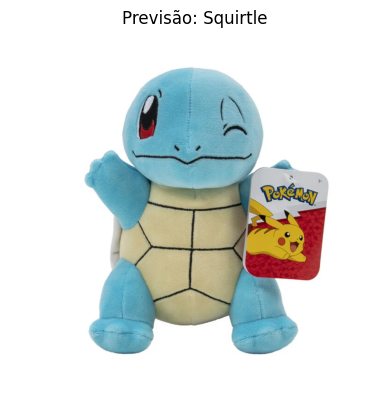

Imagem: pokemon_pelucia_de_20cm_squirtle_sunny_brinquedos_7350_1_138ce6e3e5aca1b5c8304df9435338a3.webp - Rótulo previsto: Squirtle


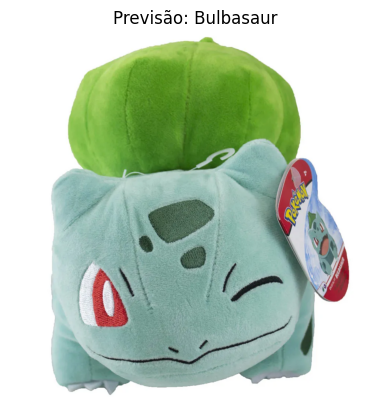

Imagem: pokemon_pelucia_de_20_cm_bulbasaur_sunny_3725_1_71b8a736a8b78e1e3730fbc508a14dd2.webp - Rótulo previsto: Bulbasaur


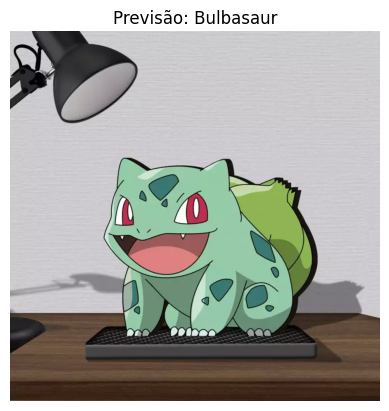

Imagem: thumb_750-750-mini-toten-display-de-mesa-pokemon-bulbasauro-1.webp - Rótulo previsto: Bulbasaur


In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os

# Função para carregar uma imagem e realizar previsões
def predict_image(image_path, model, class_names, transform, device):
    # Carregar a imagem e aplicar as transformações
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image).unsqueeze(0)  # Adiciona uma dimensão para o batch
    
    # Mover a imagem para o dispositivo (GPU/CPU)
    image_transformed = image_transformed.to(device)
    
    # Colocar o modelo em modo de avaliação
    model.eval()
    
    with torch.no_grad():
        # Fazer a previsão
        output = model(image_transformed)
        _, predicted = torch.max(output, 1)
    
    # Obter o rótulo previsto
    predicted_class = class_names[predicted.item()]
    
    # Mostrar a imagem e o rótulo previsto
    plt.imshow(image)
    plt.title(f'Previsão: {predicted_class}')
    plt.axis('off')
    plt.show()
    
    return predicted_class

# Função para realizar previsões em todas as imagens de um diretório
def predict_images_in_folder(folder_path, model, class_names, transform, device):
    # Iterar por todos os arquivos na pasta
    for file_name in os.listdir(folder_path):
        # Obter o caminho completo da imagem
        image_path = os.path.join(folder_path, file_name)
        
        # Verificar se é um arquivo de imagem
        if os.path.isfile(image_path) and image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp', '.jfif')):
            try:
                # Realizar a previsão para a imagem
                predicted_label = predict_image(image_path, model, class_names, transform, device)
                print(f"Imagem: {file_name} - Rótulo previsto: {predicted_label}")
            except Exception as e:
                print(f"Erro ao processar a imagem {file_name}: {e}")

# Carregar o modelo treinado
model.load_state_dict(torch.load(r'modelo_pokemon.pth'))
model = model.to(device)

# Lista de nomes das classes (ordem deve ser a mesma usada em ImageFolder)
class_names = train_data.classes

# Transformação usada na validação
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Caminho para a pasta de imagens a serem previstas
image_folder_path = r"C:\Users\filip\OneDrive\Área de Trabalho\Deep_learning\imagens"

# Realizar previsões em todas as imagens da pasta
predict_images_in_folder(image_folder_path, model, class_names, val_transform, device)
